# Analysis of Benchmarking Results for Partitioned LSMTree w/ Write-Ahead-Logs

In [2]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 100)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
ops = ['put', 'get', 'delete']

In [3]:
background_color = '#fcfcfc'
old_background_color = plt.rcParams['axes.edgecolor']
for k,v in plt.rcParams.items():
    if v == old_background_color:
        plt.rcParams[k] = background_color

In [4]:
figdir = 'figures/lsm_part_log'
!mkdir -p $figdir

# Loading Data

In [126]:
specs = pd.concat([pd.read_json('results/lsm_part_log/specs.jsonl', lines=True),
                   pd.read_json('results/partitioned_lsm/benchmark_part_lsm_specs.jsonl', lines=True)],
                 axis=0)
print(len(specs))
specs.head()

472


,spec,created_at,events,id,last_modified,status
0,"{'partitions': 4, 'seconds': 600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key_...",2020-05-03 22:34:37.049059,"[{'msg': 'starting', 'hostname': 'ec2-34-209-66-134.us-west-2.compute.amazonaws.com', 'time': '2...",44fc758c-8d8e-11ea-b1d1-00155d010301,2020-05-04T00:14:02.312176,succeeded
1,"{'partitions': 4, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-05-04 11:17:35.801702,"[{'msg': 'starting', 'hostname': 'ec2-54-202-44-63.us-west-2.compute.amazonaws.com', 'time': '20...",dacdb08d-8df8-11ea-b1d1-00155d010301,2020-05-04T13:26:18.438428,succeeded
2,"{'partitions': 4, 'seconds': 600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key_...",2020-05-03 22:34:35.611344,"[{'msg': 'starting', 'hostname': 'ec2-34-221-193-102.us-west-2.compute.amazonaws.com', 'time': '...",43c71f39-8d8e-11ea-b1d1-00155d010301,2020-05-04T00:04:14.658527,succeeded
3,"{'partitions': 8, 'seconds': 3600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key...",2020-05-04 11:17:35.054131,"[{'msg': 'starting', 'hostname': 'ec2-35-163-218-66.us-west-2.compute.amazonaws.com', 'time': '2...",dacdb084-8df8-11ea-b1d1-00155d010301,2020-05-04T12:25:51.800871,succeeded
4,"{'partitions': 8, 'seconds': 600, 'value_length': 1024, 'key_space_size': 100000000, 'known_key_...",2020-05-03 22:34:40.627650,"[{'msg': 'starting', 'hostname': 'ec2-34-221-193-102.us-west-2.compute.amazonaws.com', 'time': '...",463380b0-8d8e-11ea-b1d1-00155d010301,2020-05-03T23:03:24.323501,succeeded


In [127]:
specs['status'].value_counts()

succeeded    421
cancelled     45
failed         6
Name: status, dtype: int64

In [128]:
results = pd.concat([
    pd.read_json('results/lsm_part_log/results.jsonl', lines=True, convert_dates=False),
    pd.read_json('results/partitioned_lsm/benchmark_part_lsm_results.jsonl', lines=True, convert_dates=False)],
    axis=0)
print(len(results))
results.sample(5)

89495


,delete,get_found,spec_id,delete_found,get,file_size,put,nano_time
11729,51923,4750,5aa705b8-8ac6-11ea-b1d1-00155d010301,51923,51685,29215170509,935467,3926938700743
4244,106252,376302,5b6b290e-8ac6-11ea-b1d1-00155d010301,106252,1800983,39491204409,211990,3041615127855
2369,85405,81992,416dd586-8d8e-11ea-b1d1-00155d010301,85405,1450143,6993528986,171090,6593082155898
17575,19577,6348,d7a81a08-8df8-11ea-b1d1-00155d010301,19577,19634,58077180779,350117,2537769383540
8405,105314,6748,5ca56831-8ac6-11ea-b1d1-00155d010301,105314,23348,86196749126,104781,10043581710831


## Preprocess Results

In [129]:
constant_parameters = ['seconds', 'value_length', 'key_space_size', 'known_key_rate_percent', 'trial_index',
                       'pending_write_merge_threshold', 'index_rate']

In [130]:
spec_values = pd.concat([specs[['id', 'status']], pd.DataFrame(list(specs['spec']), index=specs.index)], axis=1)
spec_values['workload'] = spec_values['put_del_get']
spec_values['index_rate'] = spec_values['base_index_rate']
spec_values = spec_values.drop(['put_del_get', 'base_index_rate'], axis=1)
spec_values = spec_values[spec_values['seconds'] == 3600]
for param in constant_parameters:
    assert spec_values[param].nunique() == 1, f'{param} is not constant'
spec_values = spec_values.drop(constant_parameters, axis=1)
spec_values.loc[spec_values['sync_frequency_ms'].isna(), 'sync_frequency_ms'] = -1
spec_values.sample(5)

,id,status,partitions,sync_frequency_ms,thread_count,workload
41,d36ff0f9-8ac0-11ea-b1d1-00155d010301,cancelled,8,-1.0,16,BALANCED
185,58ae0b2f-8de5-11ea-b1d1-00155d010301,succeeded,1,100.0,1,BALANCED
36,59bde421-8de5-11ea-b1d1-00155d010301,succeeded,1,1000.0,4,GET_HEAVY
51,d36ff0f7-8ac0-11ea-b1d1-00155d010301,cancelled,1,-1.0,16,BALANCED
38,d4712904-8ac0-11ea-b1d1-00155d010301,cancelled,8,-1.0,1,BALANCED


In [131]:
grouped_results = []
for spec_id, spec_results in results.groupby('spec_id'):
    spec_results = spec_results.sort_values('nano_time')
    spec_results['t'] = (spec_results['nano_time'] - spec_results['nano_time'].iloc[0]) / 1e9
    grouped_results.append({
        'spec_id': spec_id,
        'results': spec_results,
        'final_file_size': spec_results['file_size'].iloc[-12::].max(),
        'sum_put': spec_results['put'].sum(),
        'sum_get': spec_results['get'].sum(),
        'sum_delete': spec_results['delete'].sum()
    })
grouped_results = pd.DataFrame(grouped_results)
grouped_results = pd.concat([spec_values.set_index('id'), grouped_results.set_index('spec_id')], axis=1)
grouped_results = grouped_results.dropna()
grouped_results = grouped_results[grouped_results['status'].isin(['succeeded', 'running'])]
grouped_results.sample(5).T

,59bde420-8de5-11ea-b1d1-00155d010301,58db5278-8a7c-11ea-b1d1-00155d010301,59bde410-8de5-11ea-b1d1-00155d010301,5ca56831-8ac6-11ea-b1d1-00155d010301,5aef4f52-8de5-11ea-b1d1-00155d010301
status,succeeded,succeeded,succeeded,succeeded,succeeded
partitions,1,1,1,8,1
sync_frequency_ms,100,-1,0,-1,10
thread_count,4,8,1,8,1
workload,GET_HEAVY,BALANCED,PUT_HEAVY,DELETE_HEAVY,DELETE_HEAVY
results,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_siz...,delete get_found spec_id delete_found get file_size ...,delete get_found spec_id delete_found get file_si...,delete get_found spec_id delete_found get file_siz...
final_file_size,5.30199e+10,7.53237e+10,4.00794e+10,1.2839e+11,9.45208e+10
sum_put,3.50161e+07,7.66875e+07,2.43986e+07,1.71659e+08,7.53037e+07
sum_get,2.97505e+08,7.90036e+07,1.3548e+06,3.81482e+07,1.6734e+07
sum_delete,1.75007e+07,7.66831e+07,1.35446e+06,1.71651e+08,7.52854e+07


In [132]:
grouped_results['status'].value_counts()

succeeded    205
Name: status, dtype: int64

In [133]:
normed_results = grouped_results.copy()
normed_results['duration_seconds'] = normed_results['results'].map(lambda r: r['t'].max())
for op in ops:
    normed_results[op] = normed_results['sum_' + op] / normed_results['duration_seconds'] / 1000
normed_results = normed_results.drop(['results'] + ['sum_' + op for op in ops], axis=1)
normed_results['sum'] = normed_results[ops].sum(axis=1)
normed_results['final_file_size'] /= 1e9
normed_results = normed_results.set_index(['workload', 'sync_frequency_ms', 'partitions', 'thread_count'])
normed_results.sample(5)

status  final_file_size  duration_seconds        put         get     delete         sum
workload  sync_frequency_ms partitions thread_count                                                                                            
BALANCED  -1.0              16.0       32.0          succeeded        96.244198       3593.249040  57.012987   58.746581  57.007914  172.767482
           0.0              8.0        32.0          succeeded        68.128798       3590.764525  13.906667   14.324507  13.900705   42.131880
          -1.0              16.0       8.0           succeeded        80.260195       3591.872763  52.456575   54.045624  52.453625  158.955824
GET_HEAVY -1.0              4.0        16.0          succeeded        76.629319       3590.677592  15.329707  130.324766   7.667655  153.322127
                            8.0        4.0           succeeded        40.216455       3590.767194  16.003534  136.033787   8.002108  160.039429

status  final_file_size  duration_seconds        put         get     delete         sum
workload  sync_frequency_ms partitions thread_count                                                                                            
GET_HEAVY -1.0              16.0       16.0          succeeded        47.681172       3591.310145  22.302867  189.566083  11.150334  223.019283
                                       32.0          succeeded        47.070160       3590.991873  21.914461  186.275188  10.955782  219.145431
                                       8.0           succeeded        48.020711       3591.289617  20.898180  177.627025  10.447938  208.973143
           100.0            16.0       32.0          succeeded        51.514756       3591.157711  20.333302  172.834476  10.166138  203.333916
                                       16.0          succeeded        51.424061       3591.402618  20.277326  172.344595  10.137730  202.759651

status  final_file_size  duration_seconds       put       get    delete       sum
workload     sync_frequency_ms partitions thread_count                                                                                      
DELETE_HEAVY 0.0               1.0        4.0           succeeded        23.480966       3590.418309  3.624137  0.805645  3.625251  8.055032
                                          1.0           succeeded        11.828165       3590.293267  3.463348  0.770220  3.465441  7.699008
PUT_HEAVY    0.0               1.0        1.0           succeeded        40.079404       3590.341349  6.795633  0.377345  0.377251  7.550229
                                          8.0           succeeded        38.508527       3590.332669  6.711858  0.372714  0.373294  7.457866
                                          4.0           succeeded        22.372517       3590.465539  6.681209  0.371016  0.371548  7.423773

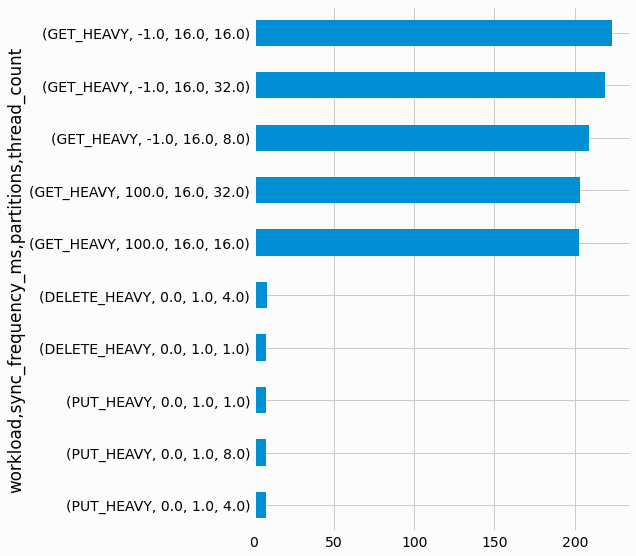

In [134]:
x = normed_results.sort_values('sum', ascending=False)
display(x.head())
display(x.tail())
pd.concat([x['sum'].head(), x['sum'].tail()]).iloc[::-1].plot.barh(figsize=(6,9))

# Analaysis

In [143]:
workload_to_color = {
    'BALANCED': '#008fd5',
    'DELETE_HEAVY': '#fc4f30',
    'PUT_HEAVY': '#e5ae38',
    'GET_HEAVY': '#6d904f'
}
thread_to_color = dict(zip(sorted(set(spec_values['thread_count'])), colors))
partition_to_ls = dict(zip(sorted(set(spec_values['partitions'])), ['-', '--', ':']))
partition_to_marker = dict(zip(sorted(set(spec_values['partitions'])), ['o', 's', '^', '*']))

def select_highest_performing_thread_count(df):
    s = df.set_index('thread_count')['sum']
    i = s.idxmax()
    return pd.Series({'thread_count': i, 'sum': s[i]})

def add_bar_values(ax, x, sep='\n', standard_index=0):
    standard_value = x.iloc[standard_index]
    for i, v in enumerate(x):
        ax.text(v + 10, i, f'{v:.1f}' + 
                ('' if i==standard_index else f'{sep}({100 * (v - standard_value) / standard_value:+.1f}%)'), 
                verticalalignment='center',
                bbox=dict(facecolor=background_color, alpha=1))
        
def label_sync_freq(s):
    if s == -1:
        return 'No Log'
    if s == 0:
        return 'Always'
    return str(int(s))

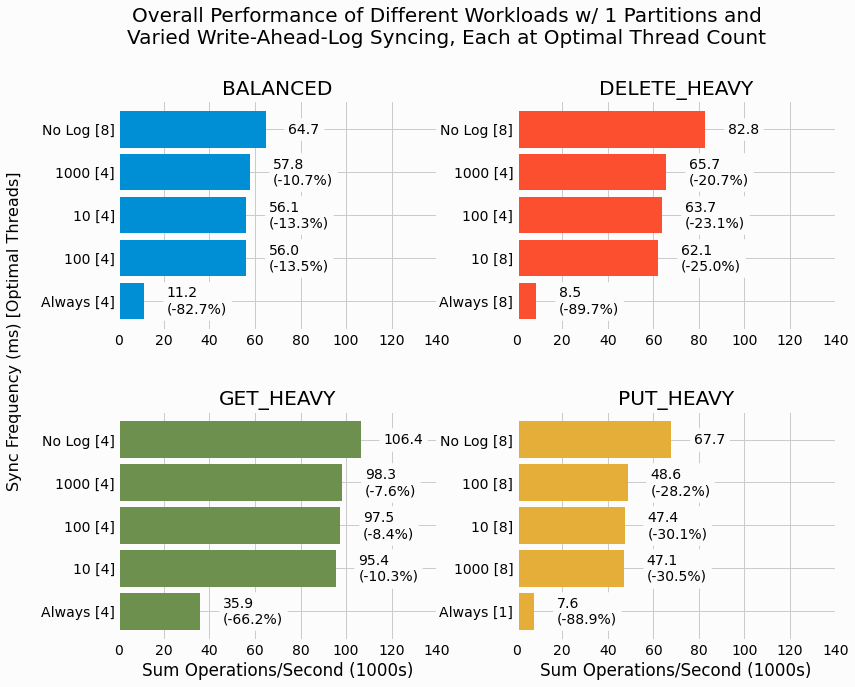

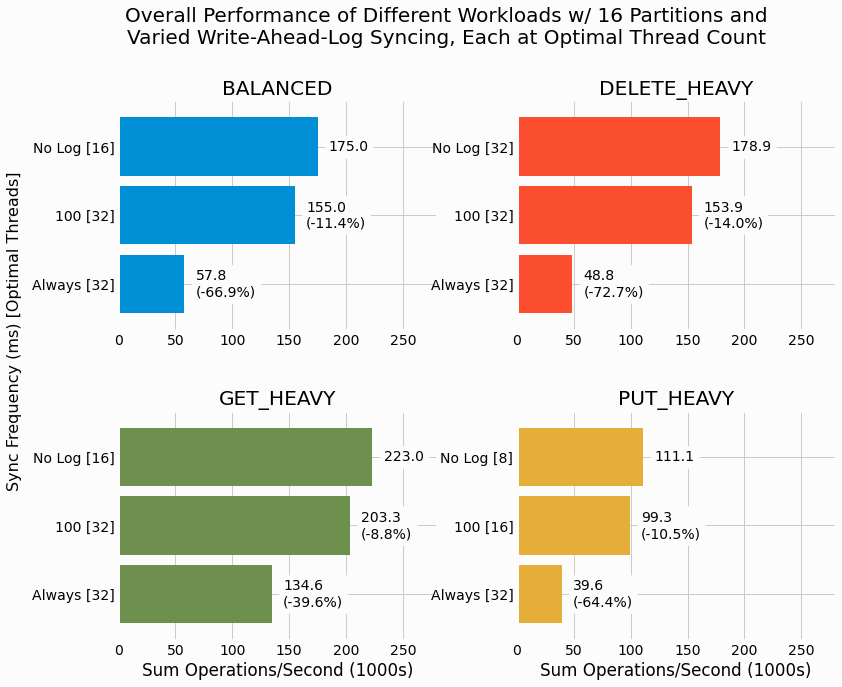

In [146]:
def partition_plot(partitions, x_max):
    fig = plt.figure(figsize=(12, 10))
    x = normed_results.reset_index()
    x = x[x['partitions'] == partitions]
    for ax_i, (workload, workload_df) in enumerate(x.groupby('workload')):
        ax = fig.add_subplot(2, 2, 1+ax_i)
        ax.set_title(workload)

        workload_df = workload_df.reset_index().groupby('sync_frequency_ms').apply(select_highest_performing_thread_count)
        x = workload_df.reset_index().set_index(['sync_frequency_ms', 'thread_count'])['sum'].sort_values(ascending=True)
        x.plot.barh(ax=ax, color=workload_to_color[workload], width=0.85)
        
        [[never_index]] = np.where(x.reset_index()['sync_frequency_ms'] == -1)
        add_bar_values(ax, x, standard_index=never_index)

        ax.set_yticklabels([f'{label_sync_freq(s)} [{int(t)}]' for s,t in x.index])

        plt.xlim(0, x_max)
        if ax_i>=2:
            ax.set_xlabel('Sum Operations/Second (1000s)')
        ax.set_ylabel('')
    fig.text(0, 0.5, 'Sync Frequency (ms) [Optimal Threads]', rotation=90,
             verticalalignment='center', horizontalalignment='center', size=16)

    fig.subplots_adjust(hspace=0.35, top=0.82, wspace=0.25, left=0.12)
    fig.suptitle('Overall Performance of Different Workloads w/ ' +
                 f'{partitions} Partition{"s" if partitions > 0 else ""} and\n' +
                 'Varied Write-Ahead-Log Syncing, Each at Optimal Thread Count', 
                 y=0.95, size=20)
    plt.savefig(figdir + f'/overall_performance_{partitions}partitions.png', bbox_inches='tight')
    
partition_plot(1, 140)
partition_plot(16, 280)

# Time Dependent Analysis

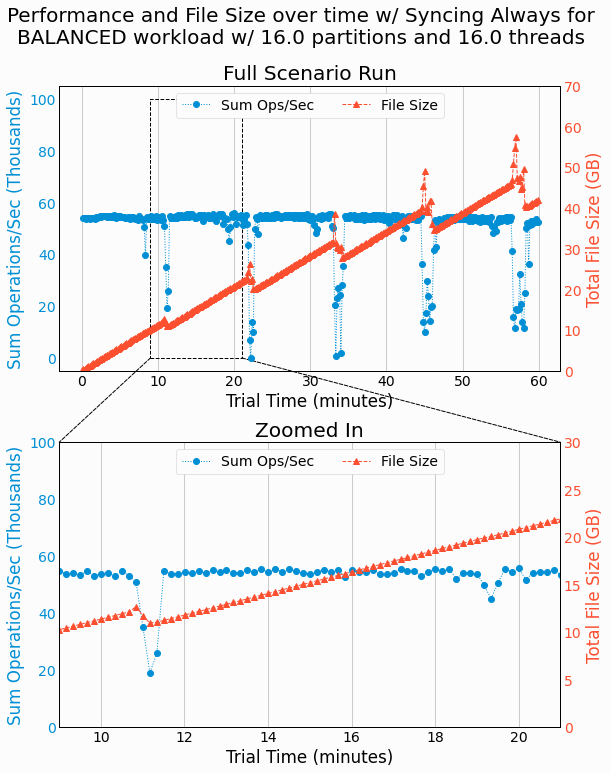

In [150]:
import matplotlib.patches as patches

def diff(x):
    return x.iloc[1::].reset_index(drop=True) - x.iloc[:-1:].reset_index(drop=True)

def prepare_t_ops_sec(workload, partitions, thread_count, sync_freq):
    r = grouped_results
    r = r[r['workload'] == workload]
    r = r[r['partitions'] == partitions]
    r = r[r['thread_count'] == thread_count]
    r = r[r['sync_frequency_ms'] == sync_freq]

    assert len(r) == 1
    r = r.iloc[0]
    x = r['results']
    x = x.copy()

    t = x['t'] / 60
    ops_sec = (x[['put', 'get', 'delete']].sum(axis=1).iloc[1::].reset_index(drop=True) /
                diff(x['t']))
    ops_sec /= 1000
    return r, t, ops_sec, x['file_size'] / 1e9
    
def plot_ops_size_one(t, ops_sec, file_size, ax1):
    ax2 = ax1.twinx()

    l1, = ax1.plot(t[1::], ops_sec, color=colors[0], label='Sum Ops/Sec', marker='o', lw=1, ls=':')
    l2, = ax2.plot(t, file_size, color=colors[1], label='File Size', marker='^', lw=1, ls='--')

    ax1.grid(False, axis='y')
    ax2.grid(False, axis='y')
    ax1.legend([l1, l2], [l1.get_label(), l2.get_label()],
               loc='upper center', ncol=2, framealpha=1)
    ax1.set_ylabel('Sum Operations/Sec (Thousands)', color=colors[0])
    ax1.tick_params(axis='y', colors=colors[0])
    ax2.set_ylabel('Total File Size (GB)', color=colors[1])
    ax2.tick_params(axis='y', colors=colors[1])
    ax1.set_xlabel('Trial Time (minutes)')
    return ax2

def plot_time_dependence_zoom(workload, partitions, thread_count, sync_freq,
                              t_start, t_end, ops_lim, file_lim_full, file_lim_zoom):
    r, t, ops_sec, file_size = prepare_t_ops_sec(workload, partitions, thread_count, sync_freq)
    
    def plot_ops_size(index):
        ax1 = fig.add_subplot(2, 1, index)
        ax2 = plot_ops_size_one(t, ops_sec, file_size, ax1)
        return ax1, ax2

    with plt.rc_context({'axes.edgecolor':'k', 'axes.linewidth':1}):
        fig = plt.figure(figsize=(8,11))
        fig.subplots_adjust(hspace=0.25)

        ax1f, ax2f = plot_ops_size(1)
        rect = patches.Rectangle((t_start,0), max(5, t_end - t_start), ops_lim,
                                 linewidth=1, edgecolor='k', facecolor='none', ls='--')
        ax1f.add_patch(rect)
        ax1f.set_title('Full Scenario Run')
        ax2f.set_ylim(0, file_lim_full)

        ax1z, ax2z = plot_ops_size(2)
        ax1z.set_title('Zoomed In')


        for a,b in [[(t_start,0), (t_start, ops_lim)], [(t_end,0), (t_end, ops_lim)]]:
            conn = patches.Cocon = patches.ConnectionPatch(xyA=a, xyB=b, coordsA="data", coordsB="data",
                                                           axesA=ax1f, axesB=ax1z, color='k', lw=1, ls='--')
            ax1f.add_artist(conn)

        ax1z.set_xlim(t_start, t_end)
        ax1z.set_ylim(0, ops_lim)
        ax2z.set_ylim(0, file_lim_zoom)

        fig.suptitle(f'Performance and File Size over time w/ Syncing {label_sync_freq(sync_freq)} for\n' +
                     f'{r["workload"]} workload w/ {r["partitions"]} partitions and {r["thread_count"]} threads'
                     ,y=0.98, size=20)
        
    return fig, ax1f, ax2f, ax1z, ax2z
        
        

plot_time_dependence_zoom('BALANCED', partitions=16, thread_count=16, sync_freq=0,
                          t_start=9, t_end=21, ops_lim=100, file_lim_full=70, file_lim_zoom=30)
plt.savefig(figdir + '/time_dependent_balanced_sync0_16partitions_16_threads.png', bbox_inches='tight')


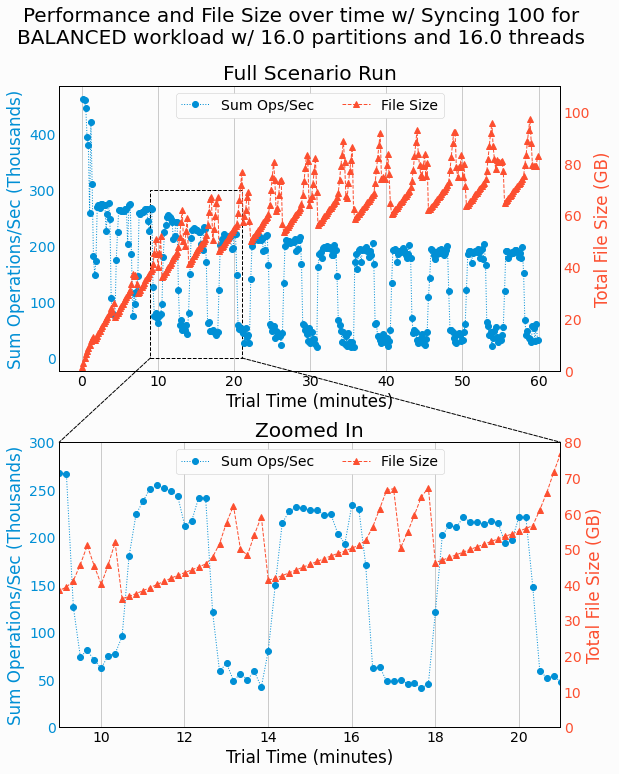

In [154]:
plot_time_dependence_zoom('BALANCED', partitions=16, thread_count=16, sync_freq=100,
                          t_start=9, t_end=21, ops_lim=300, file_lim_full=110, file_lim_zoom=80)
plt.savefig(figdir + '/time_dependent_balanced_sync100_16partitions_16_threads.png', bbox_inches='tight')
